# FEXHIS

The aim of the present notebook is to present the image preprocessing steps and test the correct execution of the automatic segmentation model as described in the article: "Automatic Segmentation of Cortical Bone Microstructure: Application and Analysis of Three Proximal Femur Sites".

The main steps are the following:
- Define the different paths
- Load manual segmentations performed by multiple operators
- Show example of data augmentation
- Load automatic segmentation model
- Show example of automatic segmentation

This notebook assumes that the FEXHIS conda environment was created using the given requirement files

In [12]:
# Initialize

"""
Start importing the necessary packages and define specific functions and paths.
"""

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import joblib
import numpy as np
import pandas as pd
from pathlib import Path
import SimpleITK as sitk
from sklearn import metrics
import matplotlib.pyplot as plt
from keras.models import load_model # type: ignore
from skimage.morphology import disk
from sklearn.model_selection import KFold
from scipy.stats.distributions import norm
from keras import layers, Model, callbacks
from scipy.ndimage import maximum_filter as mf
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from skimage import io, feature, color, filters, measure, morphology
from Utils import *


def SetDirectories(Name:str) -> dict:

    """
    Return full path of the main project folders into a dictionary
    """

    CWD = str(Path.cwd())
    Start = CWD.find(Name)
    WD = Path(CWD[:Start], Name)
    Dirs = [D for D in WD.iterdir() if D.is_dir()]

    Directories = {}
    Directories['CWD'] = WD
    Directories['Data'] = [D for D in Dirs if 'Data' in D.name][0]
    Directories['Scripts'] = [D for D in Dirs if 'Scripts' in D.name][0]
    Directories['Results'] = [D for D in Dirs if 'Results' in D.name][0]

    return Directories
def DataStats(Images:list, Plots=False) -> tuple:

    """
    Compute average and standard deviation of each canal
    for a list of images in the LAB space. Then, fit a
    normal distribution to these values and return the
    resulting parameters into two arrays
    """

    # Unfold Images list
    Images = [ii for i in Images for ii in i]
    Averages = np.zeros((len(Images),3))
    Stds = np.zeros((len(Images),3))

    # Store average and standard deviation in lab space
    for i, Image in enumerate(Images):
        LAB = color.rgb2lab(Image)
        Averages[i] = np.mean(LAB, axis=(0,1))
        Stds[i] = np.std(LAB, axis=(0,1), ddof=1)

    # Fit normal distribution
    aL = norm.fit(Averages[:,0])
    aA = norm.fit(Averages[:,1])
    aB = norm.fit(Averages[:,2])

    sL = norm.fit(Stds[:,0])
    sA = norm.fit(Stds[:,1])
    sB = norm.fit(Stds[:,2])
            
    return (np.array([aL, aA, aB]), np.array([sL, sA, sB]))
def StainAugmentation(Images:list, aLAB:np.array, sLAB:np.array, N:int) -> np.array:

    """
    Perform stain augmentation according to
        Shen et al. 2022
        RandStainNA: Learning Stain-Agnostic Features from Histology
        Slides by Bridging Stain Augmentation and Normalization
    """

    # Convert images into LAB space
    LAB = []
    S = Images[0].shape
    Time.Process(1,'Convert to LAB')
    for I in Images:
        lab = color.rgb2lab(I / 255)
        Nlab = []
        for _ in range(N):
            Nlab.append(lab)
        LAB.append(Nlab)
        Time.Update(len(LAB)/3/len(Images))
    LAB = np.array(LAB)

    # Define random transform parameters (reshape first to match data shape)
    Time.Update(1/3, 'Tranform Images')
    aLAB = np.tile(aLAB.T, N).reshape((2, N, 3), order='A')
    aLAB = np.tile(aLAB, len(Images)).reshape((2, len(Images), N, 3))
    sLAB = np.tile(sLAB.T, N).reshape((2, N, 3), order='A')
    sLAB = np.tile(sLAB, len(Images)).reshape((2, len(Images), N, 3))
    Mean = np.random.normal(aLAB[0], aLAB[1])
    Std = np.random.normal(sLAB[0], sLAB[1])

    # Normalize images according to random templates
    S = LAB.shape
    Norm = np.zeros(S)
    X_Bar = np.mean(LAB, axis=(2,3))
    S_X = np.std(LAB, axis=(2,3), ddof=1)

    X_Bar = np.tile(X_Bar, S[2]*S[3]).reshape(S)
    S_X = np.tile(S_X, S[2]*S[3]).reshape(S)
    Mean = np.tile(Mean, S[2]*S[3]).reshape(S)
    Std = np.tile(Std, S[2]*S[3]).reshape(S)

    Norm = (LAB - X_Bar) / S_X * Std + Mean

    # Convert back to RGB space
    Results = []
    Time.Update(2/3, 'Convert to RGB')
    for i in range(len(Images)):
        results = []
        for j in range(N):
            RGB = color.lab2rgb(Norm[i,j])
            results.append(RGB)
        Results.append(results)
        Time.Update(2/3 + i/3/len(Images))
    Results = np.array(Results) * 255

    Time.Process(0)

    return np.round(Results).astype('uint8')
def DataAugmentation(StainAug:np.array, N=8, ROISize=256) -> None:

    """
    Perform data augmentation and return list of augmented ROIs
    :param    StainAug: Stain augmented data
    :param           N: Augmentation factor
    :param     ROISize: Size of final ROI
    """

    ROIs = []

    Time.Process(1,'Augment Data')
    Size = StainAug.shape[0] * StainAug.shape[1]
    for s, Stains in enumerate(StainAug):
        for i, Image in enumerate(Stains):
            for n in range(N):

                # Flip image
                if np.mod(n,2)-1:
                    fImage = Image
                elif np.mod(n,4)-1:
                    fImage = Image[::-1, :, :]
                else:
                    fImage = Image[:, ::-1, :]

                # Rotate image of 90 degrees
                if n < 2:
                    rImage = fImage
                elif n < 4:
                    rImage = np.rot90(fImage,1)
                elif n < 6:
                    rImage = np.rot90(fImage,2)
                else:
                    rImage = np.rot90(fImage,3)

                # Select random location
                Min = 0
                Max = rImage.shape[0] - ROISize
                X0, Y0 = np.random.randint(Min, Max, 2)
                ROI = rImage[X0:X0+ROISize, Y0:Y0+ROISize]

                # Append to list
                ROIs.append(ROI)

        Time.Update((s+1) * (i+1) / Size)
    Time.Process(0)

    return ROIs
def Segmentation(Image:np.array, FeaturesExtractor:Model, RFc) -> np.array:

    # Record elapsed time
    Time.Process(1, 'Segment ROI')

    # Perform stain normalization
    Time.Update(1/5, 'Stain normalization')
    Norm = StainNA(Image, Reference.Mean, Reference.Std)

    # Extract features
    Time.Update(2/5, 'Extract Features')
    FE = FeaturesExtraction(FeaturesExtractor, Norm)
    Features = FE.reshape(-1, FE.shape[-1])

    # Get random forest prediction
    Time.Update(4/5, 'RF prediction')
    RFPred = RFc.predict(Features)
    RFPred = RFPred.reshape(Image.shape[:-1])

    Time.Process(0)

    return RFPred
def RemoveIsland(Mask:np.array, Threshold:int) -> np.array:

    """
    Remove island smaller than a given size
    """

    Regions = measure.label(Mask)
    Values, Counts = np.unique(Regions, return_counts=True)
    Cleaned = np.isin(Regions, Values[1:][Counts[1:] > Threshold])

    return Cleaned
def ReattributePixels(Cleaned:np.array, Mask:np.array, Values:list) -> np.array:

    """
    Modify pixel labels by the given values
    """

    Cleaned[(Cleaned == Values[1])*~Mask] = Values[0]
    Cleaned[(Cleaned == Values[1])* Mask] = Values[1]
    Cleaned[(Cleaned == Values[0])*~Mask] = Values[0]
    Cleaned[(Cleaned == Values[0])* Mask] = Values[1]

    return Cleaned
def CleanSegmentation(Pred:np.array) -> np.array:

    """
    Clean segmentation by connected component thresholding
    and thin cement lines by erosion 
    """

    # Get cement lines, Haversian canals, and osteocytes masks
    Clean = Pred.copy()
    OS = Clean == 2
    HC = Clean == 3
    CL = Clean == 4

    # Keep connected regions with more than 25 pixels
    CleanOS = RemoveIsland(OS, 25)

    # Reattribute pixels labels
    Clean = ReattributePixels(Clean, CleanOS, [1,2])

    # Keep connected regions with more than 200 pixels
    CleanHC = RemoveIsland(HC, 200)

    # Reattribute pixels labels
    Clean = ReattributePixels(Clean, CleanHC, [1,3])

    # Pad array to connect cement lines at the border
    Pad = np.pad(CL+OS, ((1,1),(1,1)), mode='constant', constant_values=True)

    # Keep connected regions with more than 300 pixels
    CleanCL = RemoveIsland(Pad, 300)

    # Thin cement lines by erosion
    CleanCL = morphology.isotropic_erosion(CleanCL, 1)
    CleanCL = CleanCL[1:-1,1:-1] * CL

    # Reattribute pixels labels
    Clean = ReattributePixels(Clean, CleanCL, [1,4])

    return Clean
def PlotOverlay(Image:np.array, Segmentation:np.array) -> None:

    # Plot overlay
    DPI=196
    S = Segmentation.shape
    Seg = np.zeros(S + (4,), 'uint8')
    Seg[Segmentation==2] = [255,   0,   0, 255]
    Seg[Segmentation==3] = [  0, 255,   0, 255]
    Seg[Segmentation==4] = [  0, 255, 255, 255]

    Figure, Axis = plt.subplots(1,1, figsize=(2*S[0]/DPI, 2*S[1]/DPI))
    Axis.imshow(Image)
    Axis.imshow(Seg.astype('uint8'), alpha=0.5)
    Axis.axis('off')
    plt.subplots_adjust(0,0,1,1, wspace=0.05, hspace=0.05)
    plt.show(Figure)

    return


Dirs = SetDirectories('FEXHIP-Histology')
List = pd.read_csv(Dirs['Data'] / 'DonorsList.csv', index_col=[0])

TrainingPath = Dirs['Data'] / 'Training'
ModelsPath = Dirs['Results'] / '01_Training'
Output = Dirs['Results'] / 'Test'
os.makedirs(Output, exist_ok=True)

In [2]:
# Perform data preprocessing steps

"""
Get training data, perform stain normalisation and data augmentation.
Save the results for automatic segmentation testing.
"""


# Collect training data
Names, Images, Labels = CVAT.GetData(TrainingPath)

# Collect individual segments as one-hot encoding
OneHot = CVAT.OneHot(Labels)

# Get common ROI
CommonName, CommonROI, SegRatio, Indices = CVAT.CommonROI()

# Compute sample weights
sWeights = CVAT.SampleWeights(OneHot, Indices, SegRatio)

# Keep only 1 occurence of common ROI
# Use agreement ratio as sample weight
ROIs = Images[~Indices]
Masks = np.expand_dims(sWeights[~Indices],-1) * OneHot[~Indices]
ROIs = np.concatenate([np.expand_dims(CommonROI, 0), ROIs])
Masks = np.concatenate([np.expand_dims(SegRatio, 0), Masks])


Collect CVAT data     [===============] 100%
Process executed in 00:00:04 (HH:MM:SS)

Perform encoding      [===============] 100%
Process executed in 00:00:01 (HH:MM:SS)

Perform encoding      [===============] 100%
Process executed in 00:00:00 (HH:MM:SS)

Compute sample weight [===============] 100%
Process executed in 00:00:00 (HH:MM:SS)



Convert to RGB        [===============] 100%
Process executed in 00:00:00 (HH:MM:SS)

Augment Data          [===============] 100%
Process executed in 00:00:00 (HH:MM:SS)


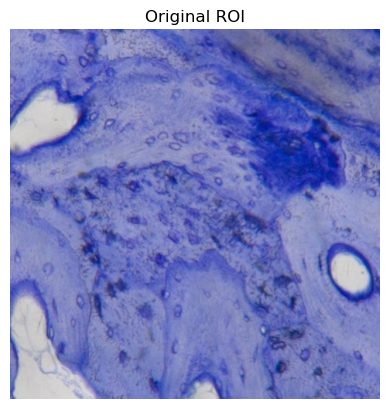

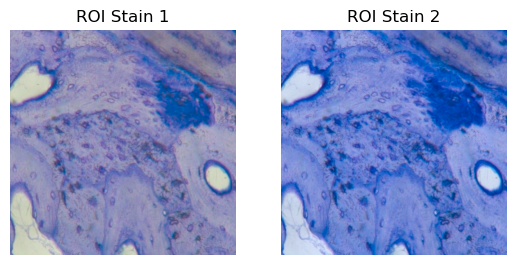

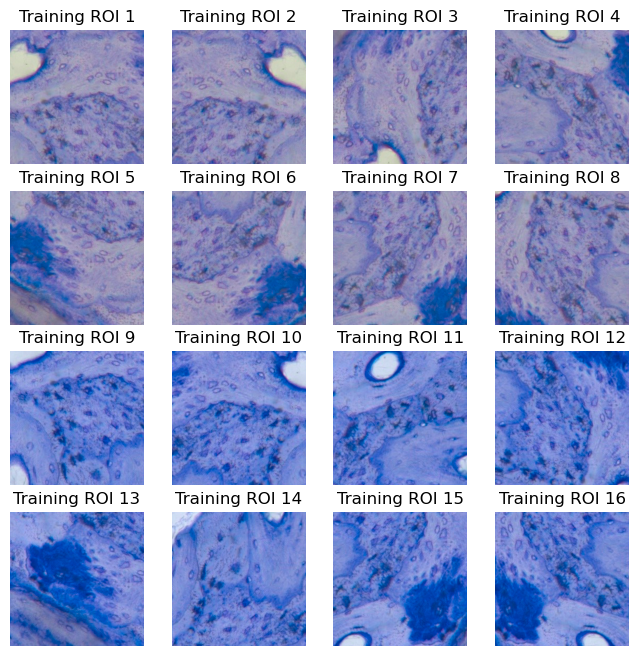

In [5]:
# Select random ROI for data augmentation
Random = np.random.randint(len(ROIs))
ROI = ROIs[Random]

# Perform stain normalization
Norm = StainNA(ROI, Reference.Mean, Reference.Std)

# Stain augmentation
N = 2
AverageLAB, StdLAB = DataStats(Images)
AverageLAB[:,0] = Reference.Mean
StdLAB[:,0] = Reference.Std
StainAug = StainAugmentation([Norm], AverageLAB, StdLAB, N)

# Perform data augmentation
AugROIs = DataAugmentation(StainAug, N=8)

# Show ROI and augmentation steps
Figure, Axis = plt.subplots(1,1)
Axis.imshow(ROI)
Axis.axis('off')
Axis.set_title('Original ROI')
plt.show(Figure)

Figure, Axis = plt.subplots(1,2)
for i in range(2):
    Axis[i].imshow(StainAug[0,i])
    Axis[i].axis('off')
    Axis[i].set_title('ROI Stain %i'%(i+1))
plt.show(Figure)

Figure, Axis = plt.subplots(4,4, figsize=(8,8))
for i in range(4):
    for j in range(4):
        k = i*4+j
        Axis[i,j].imshow(AugROIs[k])
        Axis[i,j].axis('off')
        Axis[i,j].set_title('Training ROI %i'%(k+1))
plt.show(Figure)

In [28]:
# Load best models
CNN = load_model(ModelsPath / 'UNet.hdf5')
RFc = joblib.load(str(ModelsPath / 'RandomForest.joblib'))
RFc.verbose = 0

# Select models outputs for features extractor
Outputs = [L.output for L in CNN.layers if 'conv' in L.name]
FeaturesExtractor = Model(CNN.input, Outputs)


RF prediction         [===============] 100%
Process executed in 00:00:04 (HH:MM:SS)


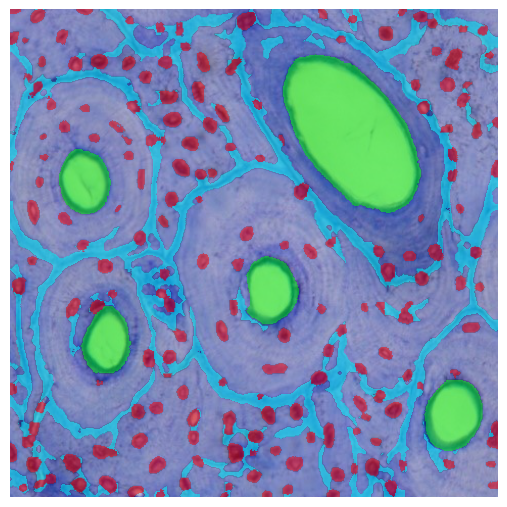

In [29]:
# Look at random test image
S = Images.shape
ImageList = np.reshape(Images, (S[0]*S[1],S[2],S[3],S[4]))
Random = np.random.randint(ImageList.shape[0])
Image = ImageList[Random]

# Perform segmentation
PredRF = Segmentation(Image, FeaturesExtractor, RFc)

# Clean cement lines segmentation
Pred = CleanSegmentation(PredRF)

# Show segmentation results
PlotOverlay(Image, Pred)